# Setup

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from experiments import data_for
from sklearn.preprocessing import StandardScaler

from experiments import experiments_matching
from models.nn import load_nn_model


def standardizer(a):
    scaler = StandardScaler()
    scaler.fit(a)
    return scaler.transform


fold = 0
n_max, l_max = 12, 6
x_train, y_train, cn_train, x_test, y_test, cn_test = \
    data_for(fold, 5, n_max, l_max, -1, False)

preprocess_x = standardizer(x_train)

config = dict(n_max=n_max, l_max=l_max)
exps = experiments_matching(model_type='nn', config=config)
best = sorted(exps, key=lambda exp: exp['results']['testing']['test_set']['mae'])[0]

nn = load_nn_model(**best['config'])

/opt/miniconda3/envs/synth-exp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from math import radians, cos, sin
import numpy as np

def rotate(thing, angle):
    theta = radians(angle)
    R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return thing @ R

def standardize_columns(x):
    return (x - x.mean(axis=0)) / x.std(axis=0)

e0 = -158.3092

In [4]:
from experiments.data import __get_structures

structures = [s for s in __get_structures(n_max, l_max) if s.info["time"] == 210]
all_soaps = np.vstack([s.arrays['soap'] for s in structures])
all_soaps.shape

(109200, 547)

In [5]:
import torch
from experiments.data import neighbour_counts

all_energies = np.concatenate([s.arrays['gap17_energy'] for s in structures])
all_cns = np.concatenate([s.arrays['coord_nums'] for s in structures])
with torch.no_grad():
    all_nn_rep = nn._net[:-2](torch.FloatTensor(preprocess_x(all_soaps)))

all_local_density = np.concatenate([neighbour_counts(s, 5) for s in structures])

# UMAP Embeddings

In [6]:
from sklearn.cluster import Birch
from collections import Counter

def clever_scatter(x, y, c, ax, n_clusters=10, s_common=2, **kwargs):
    cluster_labels = Birch(n_clusters=n_clusters).fit(np.stack([x, y], axis=-1)).labels_
    for label in np.unique(cluster_labels):
        mask = cluster_labels == label
        _x, _y, _c = x[mask], y[mask], [x for x, _m in zip(c, mask) if _m]
        _scatter_by_count(_x, _y, _c, ax, s_common=s_common, **kwargs)

def _scatter_by_count(x, y, c, ax, s=10, s_common=2, **kwargs):
    counts = Counter(c)
    zorder = 0
    for label, count in counts.most_common():
        mask = [x == label for x in c]
        ax.scatter(x[mask], y[mask], color=label, zorder=zorder, s=s_common if zorder==0 else s, **kwargs)
        zorder += 1

In [7]:
from ase.lattice.hexagonal import Graphite
from experiments.data import soap_descriptor
from ase.build import bulk

zeta = 4

graphite = Graphite(symbol='C', latticeconstant={'a': 2.46, 'c': 6.71})
graphite_soap = soap_descriptor(n_max=n_max, l_max=l_max, cutoff=3.7, atom_sigma=0.5)(graphite)[0]

diamond = bulk('C', 'diamond', cubic=True)
diamond_soap = soap_descriptor(n_max=n_max, l_max=l_max, cutoff=3.7, atom_sigma=0.5)(diamond)[0]

N_atoms_to_generate_embedding = 30_000

idxs = np.random.RandomState(42).choice(len(all_soaps), N_atoms_to_generate_embedding, replace=False)

energies = all_energies[idxs] - e0
cns = all_cns[idxs]
soaps = all_soaps[idxs]
nn_reps = all_nn_rep[idxs]
local_density = all_local_density[idxs]

graphite_sims = (soaps * graphite_soap).sum(axis=-1) ** zeta
diamond_sims = (soaps * diamond_soap).sum(axis=-1) ** zeta
def clip(x, min, max):
    return ((x - min) / (max - min)).clip(0, 1)

LOW_SOAP_LIMIT = 0.65

blues = clip(graphite_sims, LOW_SOAP_LIMIT, 1)
reds = clip(diamond_sims, LOW_SOAP_LIMIT, 1)

soap_sim_colors = np.stack([reds, np.zeros_like(blues), blues], axis=-1)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

cns_colors = {2: 'black', 3: "cornflowerblue", 4: "darkred"}
_sp_colors = np.array([cns_colors.get(cn, (0, 0, 0, 0)) for cn in cns], dtype=object)


def plot_embedding(embedding, N=-1, color_fn=None, scaling=1, equal=True, **kwargs):
    if color_fn is None:
        color_fn = lambda x: x


    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # plt.figure(figsize=(5, 5))

    axs[0].scatter(*embedding.T, c=color_fn(energies), linewidth=0, s=2*scaling, cmap="viridis", **kwargs)

    clever_scatter(*embedding[:N].T, c=_sp_colors[:N], linewidth=0, s_common=2, s=2, ax=axs[1], n_clusters=30) #, marker="s")
    # # axs[1].scatter(*embedding[:N].T, c=_sp_colors[:N], linewidth=0, s=4*scaling)

    axs[2].scatter(*embedding.T, c=soap_sim_colors, linewidth=0, s=2*scaling)

    for ax in axs:
        ax.axis('off')
        if equal:
            ax.set_aspect('equal')
    # plt.gca().axis('off')
    # plt.gca().set_aspect('equal')
    
    plt.subplots_adjust(wspace=0, hspace=0)

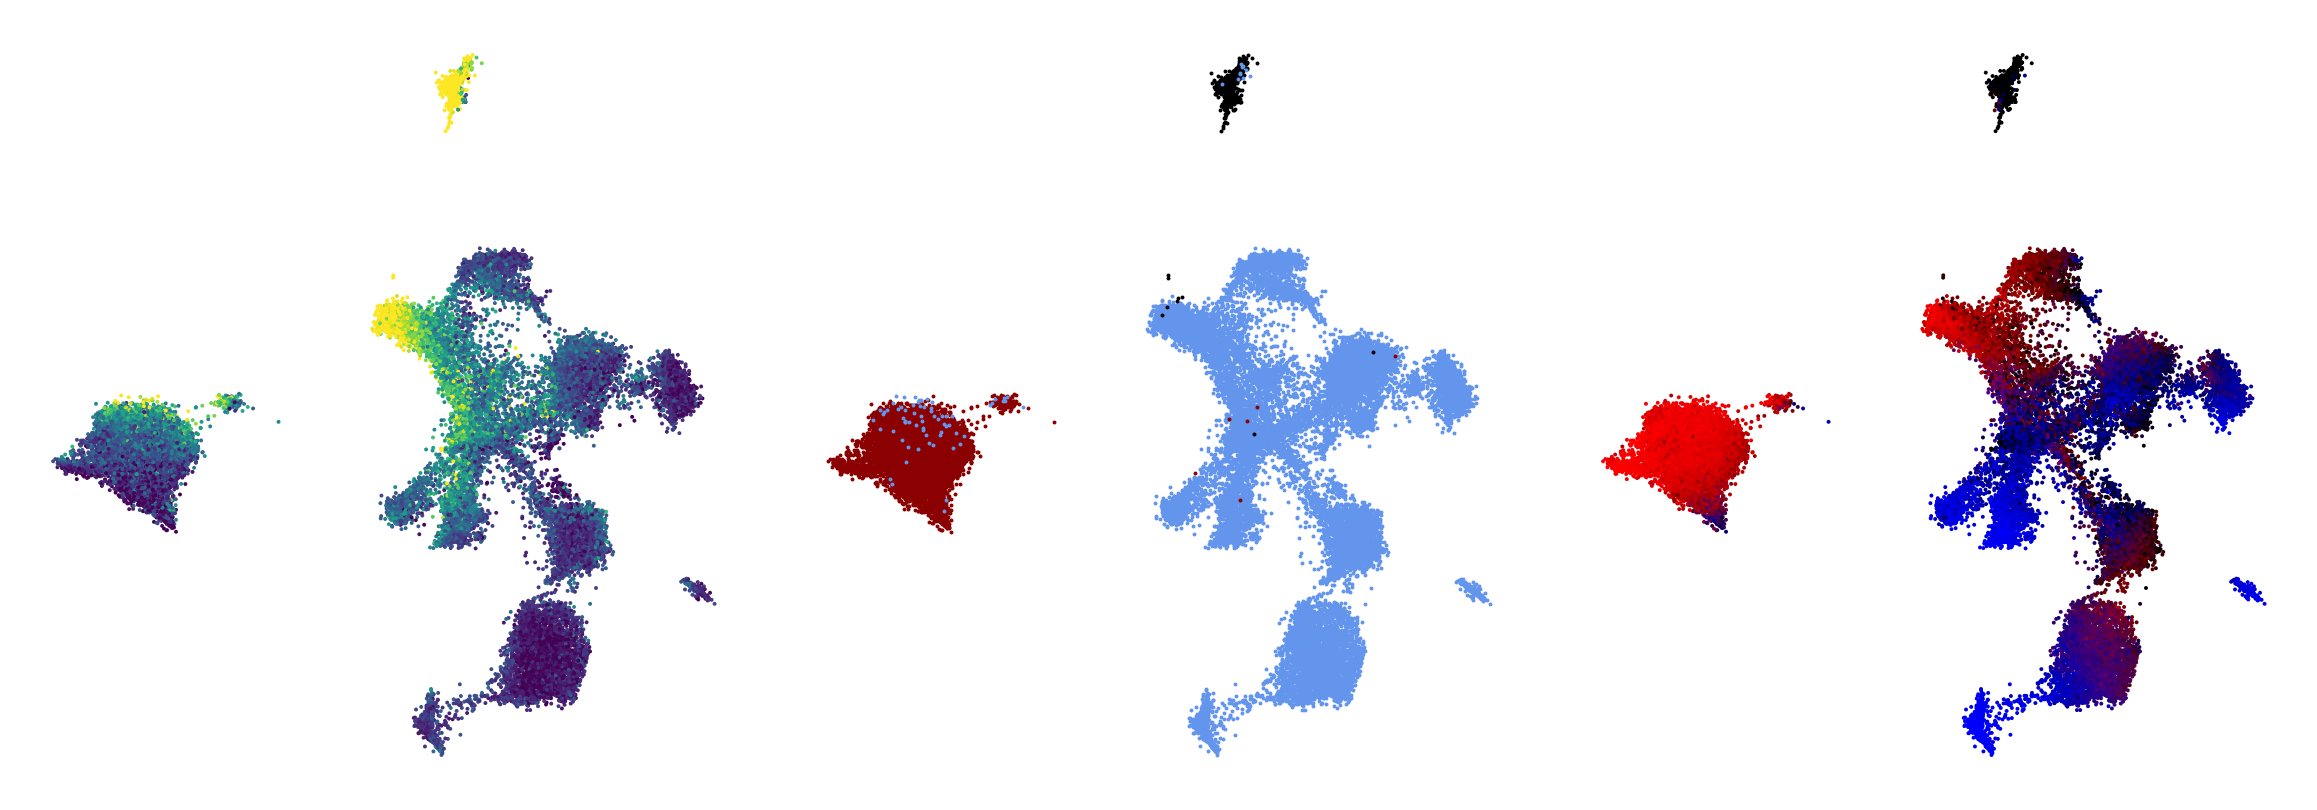

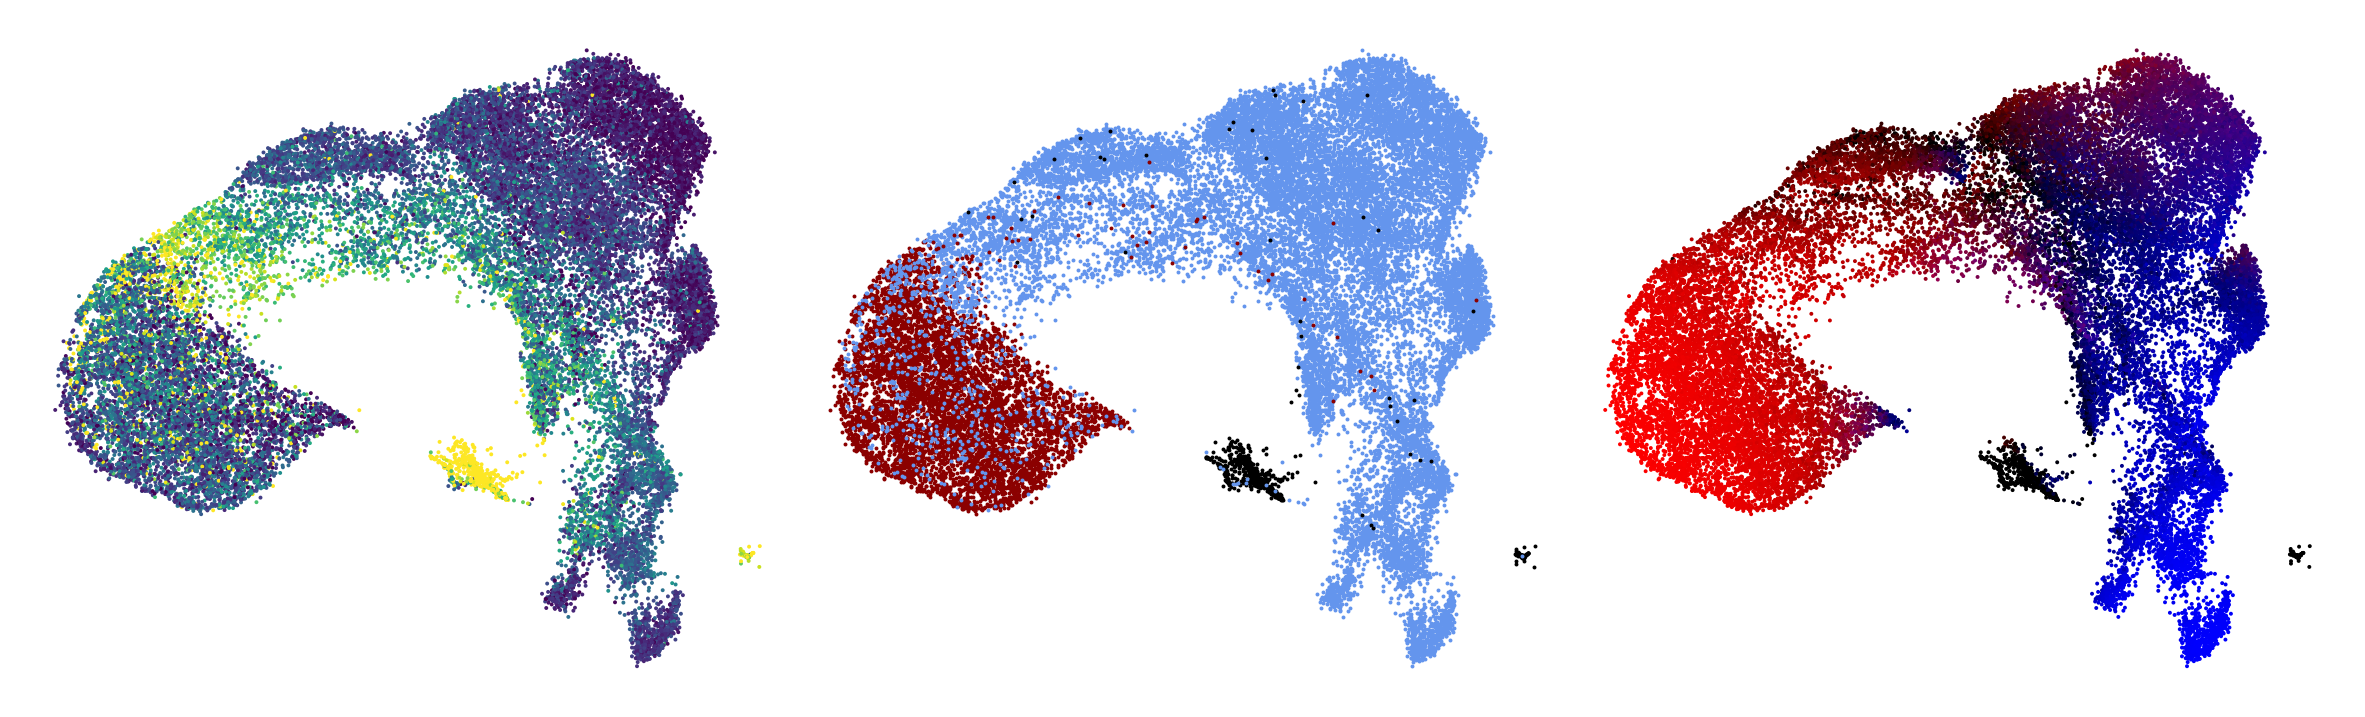

In [13]:
from umap import UMAP

umap_kwargs = {'n_neighbors': 200, 'n_epochs': 50, 'min_dist': 0.1}

soap_umap = UMAP(random_state=42, **umap_kwargs).fit_transform(soaps)
nn_umap = UMAP(random_state=42, **umap_kwargs).fit_transform(nn_reps)

plot_embedding(nn_umap, vmin=-0.1, vmax=1.5)
plt.savefig("nn-umap.png", bbox_inches='tight', dpi=200, transparent=True)
plot_embedding(soap_umap, vmin=-0.1, vmax=1.5)
plt.savefig("soap-umap.png", bbox_inches='tight', dpi=200, transparent=True)

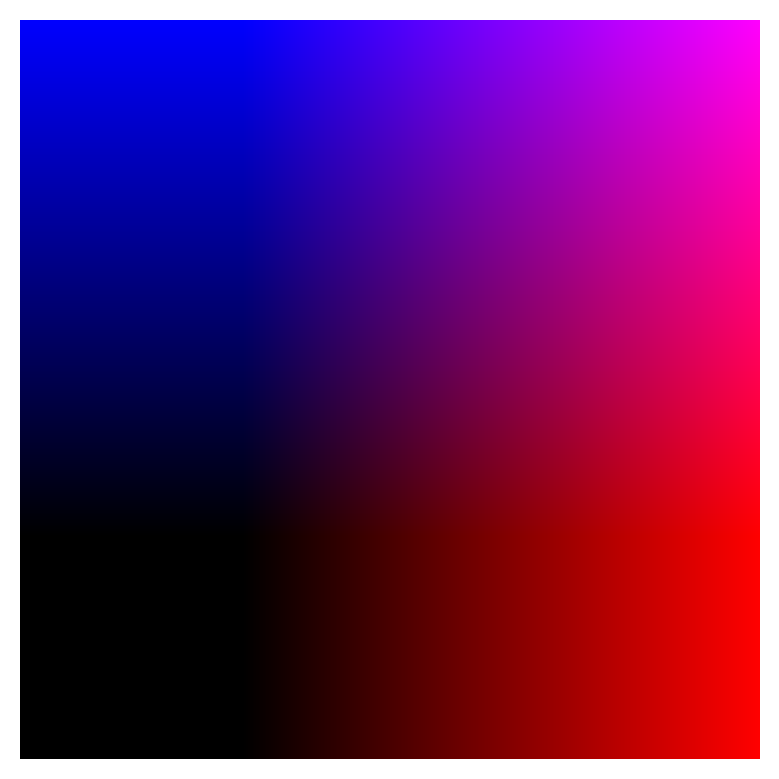

In [9]:
N = 1000
xx = np.linspace(0, 1, N)
grid = np.stack(np.meshgrid(xx, xx), axis=-1).reshape(-1, 2)
r, b = clip(grid, LOW_SOAP_LIMIT, 1).T
g = np.zeros_like(r)
colors = np.stack([r, g, b], axis=-1)

plt.imshow(colors.reshape(N, N, 3))
plt.gca().invert_yaxis()
for _, s in plt.gca().spines.items():
    s.set_visible(False)

labels = np.linspace(0, 1, 5)
ticks = np.linspace(0, N-1, 5)
plt.xticks(ticks, labels)
plt.yticks(ticks, labels);
plt.xlim(0.499*N)
plt.ylim(0.499*N)
plt.axis('off');

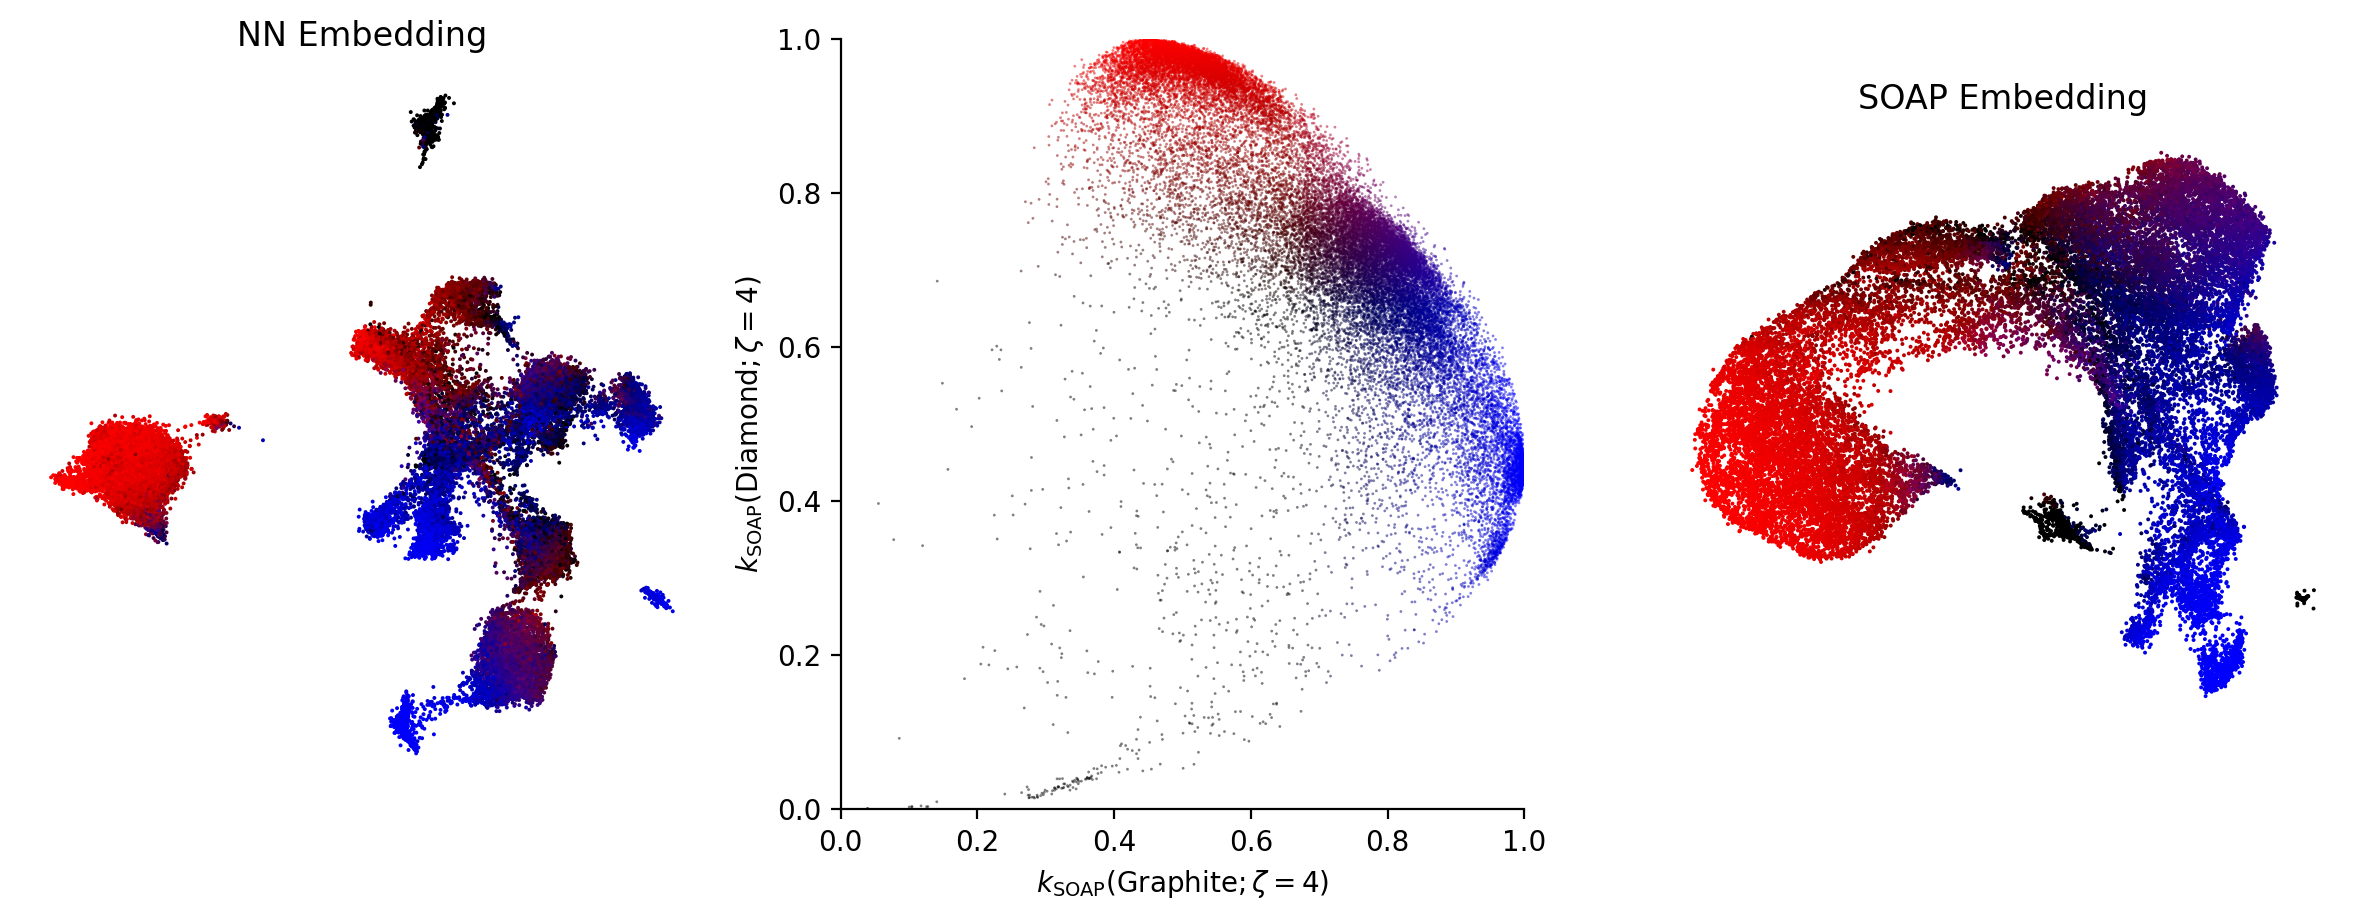

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(*nn_umap.T, linewidth=0, s=2, c=soap_sim_colors)
axs[0].set_aspect('equal')
axs[0].axis('off')
axs[0].set_title("NN Embedding")

axs[1].scatter(graphite_sims, diamond_sims, s=1, c=soap_sim_colors, linewidths=0, alpha=0.5)
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_xlabel(r"$k_{\mathrm{SOAP}}(\mathrm{Graphite}; \zeta=" + str(zeta) + ")$")
axs[1].set_ylabel(r"$k_{\mathrm{SOAP}}(\mathrm{Diamond}; \zeta=" + str(zeta) + ")$")
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

axs[2].scatter(*soap_umap.T, linewidth=0, s=2,c=soap_sim_colors)
axs[2].set_aspect('equal')
axs[2].axis('off')
axs[2].set_title("SOAP Embedding");

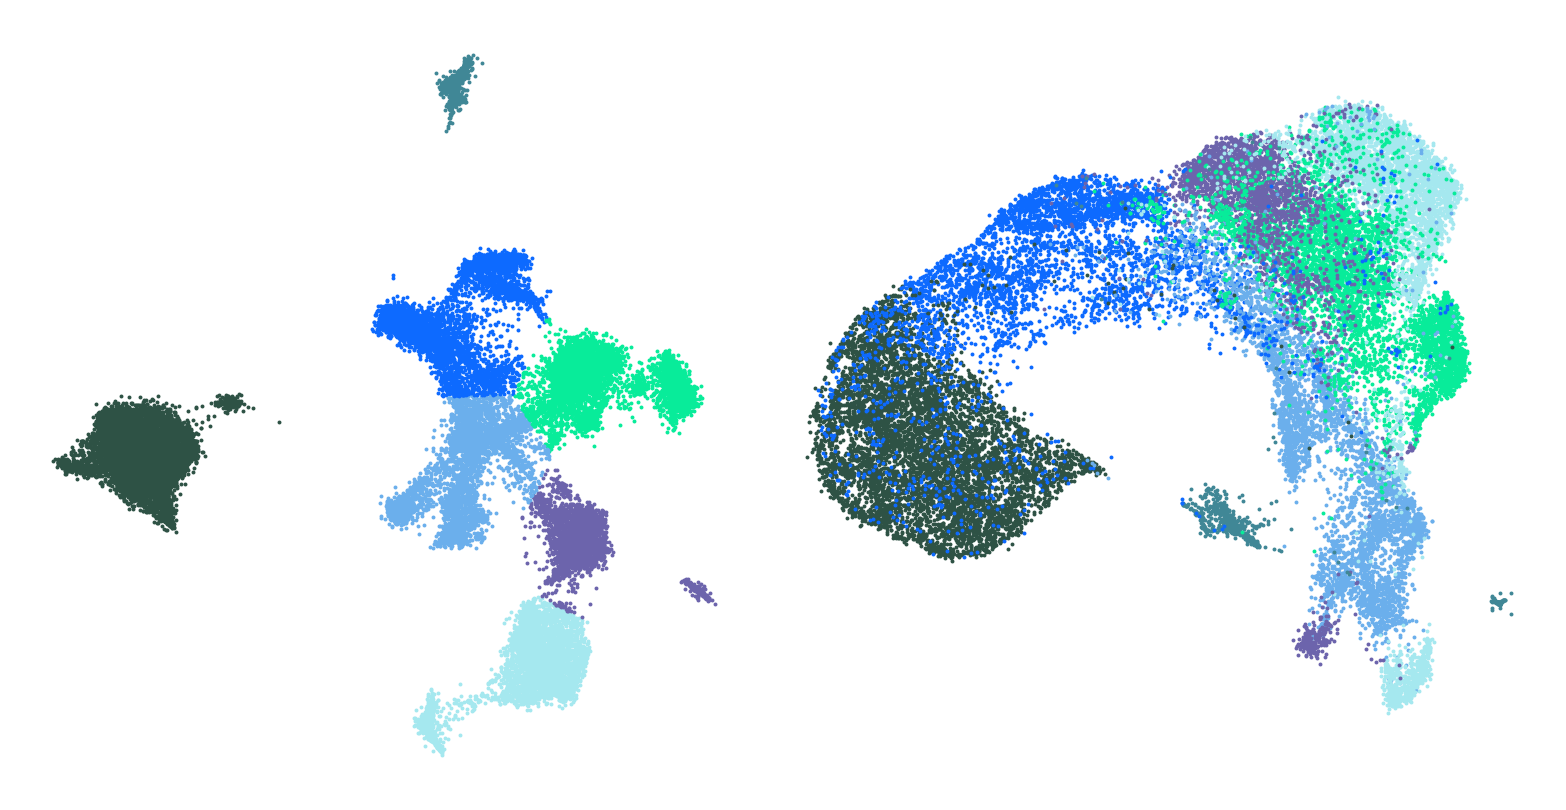

In [14]:
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
import colorcet as cc

clustering_algo = KMeans
# N = 2_000
N = -1
cmap = cc.cm.glasbey_cool
n_clusters = 7

palette = cmap(np.linspace(0, 1, n_clusters))

nn_clusters = clustering_algo(n_clusters=n_clusters).fit(nn_umap).labels_
# nn_clusters = clustering_algo(n_clusters=n_clusters).fit(nn_reps).labels_
colours = [tuple(x) for x in palette[nn_clusters]]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, data in zip(axs, [nn_umap, soap_umap]):
    clever_scatter(*data[:N].T, c=colours[:N], linewidth=0, s_common=2, s=2, ax=ax)
    ax.set_aspect('equal')
    ax.axis('off')

plt.subplots_adjust(wspace=0)
plt.savefig("nn-soap-clustering.png", bbox_inches='tight', dpi=200, transparent=True)